# __Import & config__

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('C:\\Users\\Usuario\\TFG\\digipanca\\')

In [2]:
import os
import torch
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from celluloid import Camera
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.animation as animation

from src.utils.config import load_config
from src.utils.evaluation import load_trained_model
from src.inference.predicter import Predicter2D, Predicter3D

# __Functions__

In [3]:
def predict_and_visualize(patient_id, predicter, output_dir, mode="2D"):
    """
    Predicts a patient's data, visualizes the results, and exports them.

    Parameters
    ----------
    patient_id : str
        ID of the patient to predict.
    predicter : Predicter2D or Predicter3D
        The predicter object to use for predictions.
    output_dir : str
        Directory to save the outputs.
    mode : str, optional
        Mode of prediction ("2D" or "3D"), by default "2D".
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Perform prediction
    print(f"🔍 Predicting patient {patient_id}...")
    predictions, masks = predicter.predict_patient(patient_id)

    # Convert predictions to NumPy arrays
    predictions = predictions.squeeze(0).cpu().numpy()  # (C, D, H, W)
    masks = masks.squeeze(0).cpu().numpy()              # (1, D, H, W)

    # Visualize predictions and masks as an animation
    visualize_animation(predictions, masks, output_dir, mode)

    # Visualize predictions as a 3D volume
    visualize_3d(predictions, output_dir)

    # Export predictions and masks to NIfTI
    export_to_nifti(predictions, masks, output_dir, patient_id)

def visualize_animation(predictions, masks, output_dir, mode):
    """
    Creates an animation of predictions and masks side by side.

    Parameters
    ----------
    predictions : np.ndarray
        Predicted volumes (C, D, H, W).
    masks : np.ndarray
        Ground truth masks (1, D, H, W).
    output_dir : str
        Directory to save the animation.
    mode : str
        Mode of prediction ("2D" or "3D").
    """
    print("🎥 Creating animation...")
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    camera = Camera(fig)

    # Iterate over slices
    for i in range(predictions.shape[1]):  # Iterate over depth (D)
        pred_slice = predictions[0, i, :, :]  # Channel 0 for visualization
        mask_slice = masks[0, i, :, :]

        ax[0].imshow(pred_slice, cmap="viridis")
        ax[0].set_title("Prediction")
        ax[1].imshow(mask_slice, cmap="gray")
        ax[1].set_title("Ground Truth Mask")

        camera.snap()

    animation = camera.animate()
    animation.save(os.path.join(output_dir, f"{mode}_animation.mp4"))
    print(f"✅ Animation saved to {output_dir}")

def visualize_3d(predictions, output_dir):
    """
    Creates a 3D visualization of the predicted volume.

    Parameters
    ----------
    predictions : np.ndarray
        Predicted volumes (C, D, H, W).
    output_dir : str
        Directory to save the 3D visualization.
    """
    print("📊 Creating 3D visualization...")
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")

    # Use the first channel for visualization
    volume = predictions[0]  # Shape: (D, H, W)

    # Create a 3D scatter plot
    depth, height, width = volume.shape
    x, y, z = np.meshgrid(
        np.arange(width), np.arange(height), np.arange(depth)
    )
    ax.scatter(x, y, z, c=volume.flatten(), cmap="viridis", alpha=0.5)

    ax.set_title("3D Volume Visualization")
    plt.savefig(os.path.join(output_dir, "3d_visualization.png"))
    print(f"✅ 3D visualization saved to {output_dir}")

def export_to_nifti(predictions, masks, output_dir, patient_id):
    """
    Exports predictions and masks to NIfTI format.

    Parameters
    ----------
    predictions : np.ndarray
        Predicted volumes (C, D, H, W).
    masks : np.ndarray
        Ground truth masks (1, D, H, W).
    output_dir : str
        Directory to save the NIfTI files.
    patient_id : str
        ID of the patient.
    """
    print("💾 Exporting to NIfTI...")
    pred_nifti = nib.Nifti1Image(predictions[0], affine=np.eye(4))
    mask_nifti = nib.Nifti1Image(masks[0], affine=np.eye(4))

    pred_path = os.path.join(output_dir, f"{patient_id}_predictions.nii.gz")
    mask_path = os.path.join(output_dir, f"{patient_id}_masks.nii.gz")

    nib.save(pred_nifti, pred_path)
    nib.save(mask_nifti, mask_path)

# __Predict__

In [3]:
config = load_config('configs/experiments/deep_aug_5.yaml')
model_path = 'experiments/deep_aug/deep_aug_20250415_215856/checkpoints/best_model_epoch60.pth'
model = load_trained_model(config, model_path)
config_device = config['training']['device']
device = torch.device(config_device if torch.cuda.is_available() else "cpu")
test_dir = 'data/processed/2d/train/'
patient_ids = ["rtum79", "rtum1", "rtum33", "rtum3", "rtum20", "rtum70", "rtum19", "rtum26", "rtum13", "rtum71", "rtum87", "rtum69", "rtum58", "rtum82", "rtum86", "rtum68", "rtum4", "rtum81"]

In [4]:
predicter = Predicter2D(model, config, device, test_dir)

In [5]:
patient_id = 'rtum79'
predictions, masks = predicter.predict_patient(patient_id)
print(f"predictions: {predictions.shape}")
print(f"masks: {masks.shape}")

  0%|          | 0/26 [00:00<?, ?it/s]

predictions: torch.Size([1, 5, 103, 256, 256])
masks: torch.Size([1, 103, 256, 256])


# __Functions__

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

def visualize_3d_segmentation(predictions, ground_truth, spacing, title="3D Segmentation"):
    """
    Visualize a 3D segmentation volume with predictions and ground truth side by side.

    Parameters
    ----------
    predictions : np.ndarray
        Predicted segmentation volume of shape (D, H, W).
    ground_truth : np.ndarray
        Ground truth segmentation volume of shape (D, H, W).
    spacing : tuple of float
        Spacing between voxels in the (z, y, x) dimensions.
    title : str, optional
        Title of the plot (default: "3D Segmentation").
    """
    # Create a figure with two subplots for predictions and ground truth
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    # Prepare the grid for the 3D scatter plot
    D, H, W = predictions.shape
    z, y, x = np.meshgrid(
        np.arange(D) * spacing[0],
        np.arange(H) * spacing[1],
        np.arange(W) * spacing[2],
        indexing="ij"
    )

    # Plot predictions
    pred_mask = predictions > 0  # Only plot non-background voxels
    ax1.scatter(
        x[pred_mask], y[pred_mask], z[pred_mask],
        c=predictions[pred_mask], cmap='viridis', alpha=0.5
    )
    ax1.set_title("Predictions")
    ax1.set_xlabel("X (mm)")
    ax1.set_ylabel("Y (mm)")
    ax1.set_zlabel("Z (mm)")

    # Plot ground truth
    gt_mask = ground_truth > 0  # Only plot non-background voxels
    ax2.scatter(
        x[gt_mask], y[gt_mask], z[gt_mask],
        c=ground_truth[gt_mask], cmap='viridis', alpha=0.5
    )
    ax2.set_title("Ground Truth")
    ax2.set_xlabel("X (mm)")
    ax2.set_ylabel("Y (mm)")
    ax2.set_zlabel("Z (mm)")

    # Set the main title and show the plot
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [14]:
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
CLASS_COLORS = {
    1: 'green',    # pancreas
    2: 'purple',   # tumor
    3: 'red',      # arteries
    4: 'blue',     # veins
}
def plot_segmentation_3d_v2(segmentation, title=None, alpha=0.5, spacing=(1.,.8,.8)):
    """
    Dibuja en 3D la superficie de cada clase de 'segmentation'.

    Parameters
    ----------
    segmentation : np.ndarray, shape (Z, Y, X)
        Volumen con valores enteros {0,1,2,3,4}.
    title : str, opcional
        Título de la figura.
    alpha : float
        Transparencia de las superficies.
    spacing : tuple de float
        Tamaño real de cada voxel en Z, Y, X (por si no son isotrópicos).
    """
    # Preparamos la figura
    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect((segmentation.shape[2],
                       segmentation.shape[1],
                       segmentation.shape[0]))  # X, Y, Z

    # Para cada clase (1–4)
    for cls, color in CLASS_COLORS.items():
        mask = (segmentation == cls)
        if not mask.any():
            continue  # si no hay voxels, saltamos
        # marching_cubes exige float, y un nivel de corte
        verts, faces, normals, values = measure.marching_cubes(
            mask.astype(np.float32),
            level=0.5,
            spacing=spacing
        )
        # Ajuste de orientación: marching_cubes devuelve (z, y, x) en verts ordenado
        # y el box_aspect usa (X, Y, Z), pero normalmente no necesitas permutar aquí.

        mesh = Poly3DCollection(
            verts[faces],
            facecolor=color,
            edgecolor='none',
            alpha=alpha
        )
        ax.add_collection3d(mesh)

    # Ejes y título
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    if title:
        ax.set_title(title)
    # Límites
    Z, Y, X = segmentation.shape
    ax.set_xlim(0, X)
    ax.set_ylim(0, Y)
    ax.set_zlim(0, Z)
    plt.tight_layout()
    plt.show()

# __Test__

In [8]:
from src.utils.tensors import prepare_tensors_for_visualization

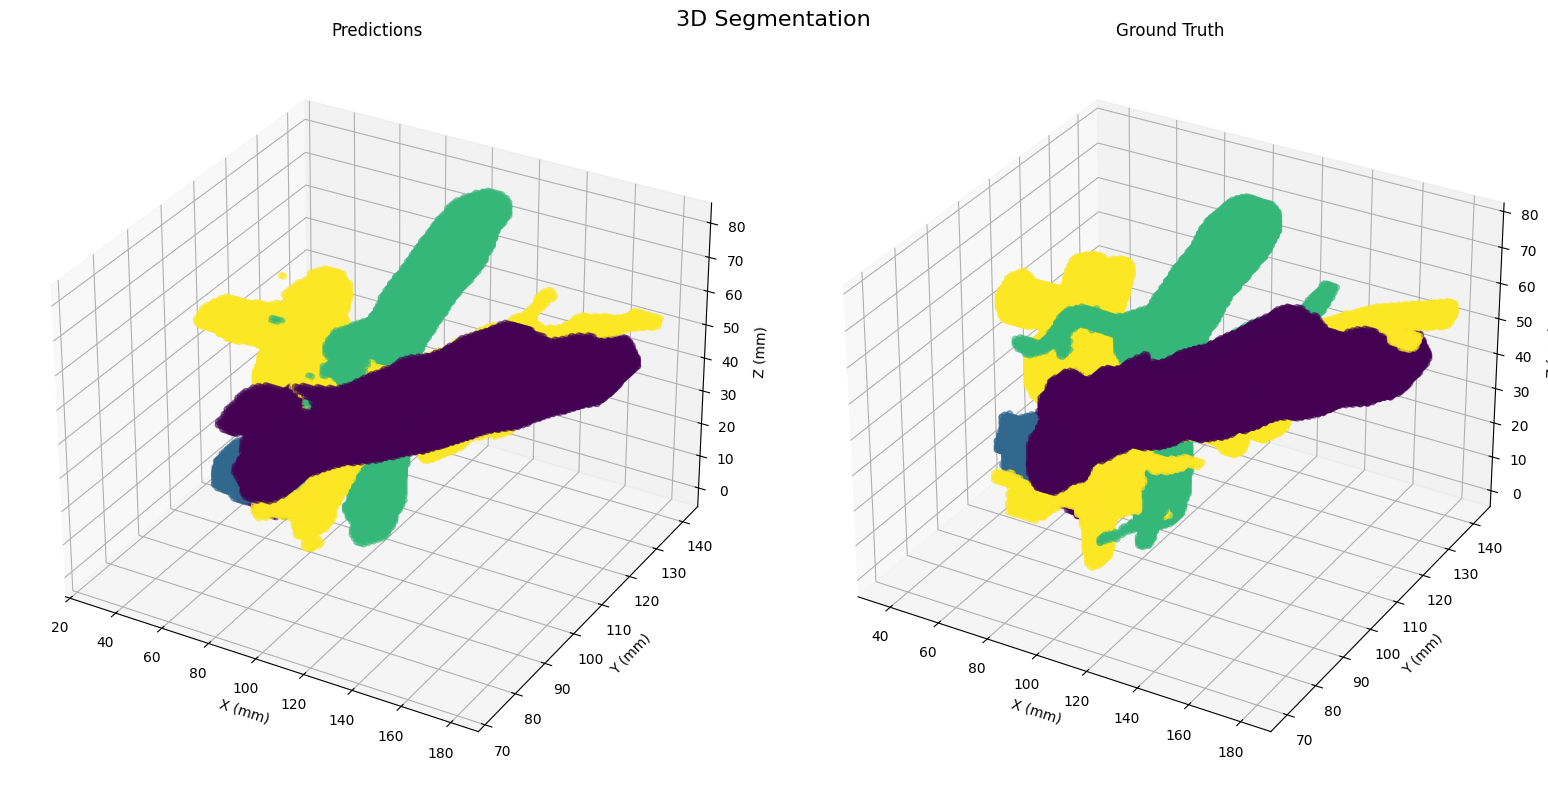

In [9]:
pred_np, mask_np, _ = prepare_tensors_for_visualization(predictions, masks, None)
visualize_3d_segmentation(pred_np, mask_np, spacing=(.8, .8, 1.))

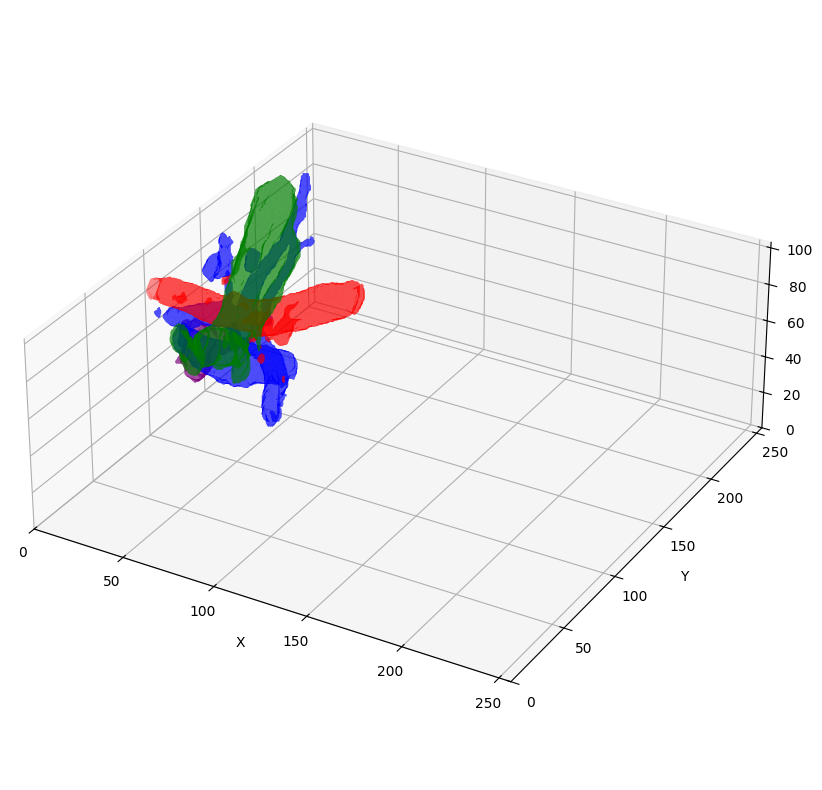

In [15]:
plot_segmentation_3d_v2(pred_np)